<a href="https://colab.research.google.com/github/JOY-246/ML_Paper/blob/main/CO%20Emition/TONY_Stark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# =========================
# 0) Setup + paths
# =========================
import os
import re
import numpy as np
import pandas as pd

BASE_PATH = "/content/drive/MyDrive/ML_new_Folder"

OBD_PATH   = os.path.join(BASE_PATH, "OBD-II Driving Data - Classified.csv")
SMART_PATH = os.path.join(BASE_PATH, "SmartWay Vehicle List for MY 2025.xlsx")
EEA_PATH   = os.path.join(BASE_PATH, "eea_s_eu-sdg-13-31_p_2000-2023_v01_r00.csv")

print("OBD:", OBD_PATH)
print("SmartWay:", SMART_PATH)
print("EEA:", EEA_PATH)

for p in [OBD_PATH, SMART_PATH, EEA_PATH]:
    print(p, "->", "OK" if os.path.exists(p) else "NOT FOUND")

OBD: /content/drive/MyDrive/ML_new_Folder/OBD-II Driving Data - Classified.csv
SmartWay: /content/drive/MyDrive/ML_new_Folder/SmartWay Vehicle List for MY 2025.xlsx
EEA: /content/drive/MyDrive/ML_new_Folder/eea_s_eu-sdg-13-31_p_2000-2023_v01_r00.csv
/content/drive/MyDrive/ML_new_Folder/OBD-II Driving Data - Classified.csv -> OK
/content/drive/MyDrive/ML_new_Folder/SmartWay Vehicle List for MY 2025.xlsx -> OK
/content/drive/MyDrive/ML_new_Folder/eea_s_eu-sdg-13-31_p_2000-2023_v01_r00.csv -> NOT FOUND


In [9]:
# =========================
# 1) Load datasets
# =========================
obd = pd.read_csv(OBD_PATH, encoding='latin1')
smart = pd.read_excel(SMART_PATH)   # first sheet by default
# eea = pd.read_csv(EEA_PATH) # Commented out due to FileNotFoundError

print("OBD shape:", obd.shape)
print("SmartWay shape:", smart.shape)
# print("EEA shape:", eea.shape) # Commented out as eea is not loaded

print("\nOBD columns:\n", obd.columns.tolist())
print("\nSmartWay columns:\n", smart.columns.tolist()[:40], "...")  # show first 40
# print("\nEEA columns:\n", eea.columns.tolist()) # Commented out as eea is not loaded

OBD shape: (555000, 35)
SmartWay shape: (763, 17)

OBD columns:
 ['Voltaje de la batería', 'Carga calculada del motor ', 'Temperatura del lí\xadquido de enfriamiento del motor', 'Ajuste de combustible a corto plazo (Banco 1) ', 'Ajuste de combustible a largo plazo (Banco 1)', 'Presión absoluta del colector de admisión ', 'RPM del motor', 'Velocidad [km/h] ', 'Avance de tiempo de encendido ', 'Temperatura del aire del colector de admisión', 'Posición absoluta del acelerador ', 'Voltaje del sensor de labda ', 'Distancia recorrida con la luz indicadora de falla encendida', 'Purga evaporativa comandada ', 'Entrada de nivel de combustible ', 'Nímero de calentamientos desde que se borraron los fallas ', 'Distancia recorrida desde que se borraron los fallas ', 'Presión barométrica ', 'Relación de equivalencia del sensor de oxigeno', 'Corriente del sensor de OÃ¢Â\x82Â', 'Temperatura del catalizador', 'Voltaje del módulo de control', 'Valor absoluto de carga ', 'Relación de equivalencia comanda

In [10]:
# =========================
# 2) Detect driving style column in OBD dataset
# =========================
def detect_style_col(df):
    candidates = []
    for c in df.columns:
        cl = str(c).lower()
        if "class" in cl or "label" in cl or "style" in cl or "behavior" in cl or "driving" in cl:
            candidates.append(c)
    return candidates

style_candidates = detect_style_col(obd)
print("Possible style columns:", style_candidates)

# Pick the first candidate automatically (you can change manually)
STYLE_COL = style_candidates[0] if len(style_candidates) else None
print("Selected STYLE_COL:", STYLE_COL)

if STYLE_COL is None:
    raise ValueError("No driving style/label column found in OBD dataset. Please check OBD columns and set STYLE_COL manually.")

print("\nUnique style values:", obd[STYLE_COL].astype(str).str.lower().value_counts().head(20))

Possible style columns: ['Label']
Selected STYLE_COL: Label

Unique style values: Label
1    436602
0    118398
Name: count, dtype: int64


In [11]:
# =========================
# 3) Detect MPG and CO2 columns in SmartWay
# =========================
def find_col(df, patterns):
    for p in patterns:
        regex = re.compile(p, re.IGNORECASE)
        for c in df.columns:
            if regex.search(str(c)):
                return c
    return None

MPG_COL = find_col(smart, [
    r"combined.*mpg", r"comb.*mpg", r"mpg.*combined", r"overall.*mpg", r"mpg"
])

CO2_COL = find_col(smart, [
    r"co2.*g.?/?.*mile", r"co2.*gpm", r"tailpipe.*co2", r"co2"
])

FUELTYPE_COL = find_col(smart, [
    r"fuel.*type", r"fueltype", r"fuel"
])

MAKE_COL = find_col(smart, [r"make", r"manufacturer"])
MODEL_COL = find_col(smart, [r"model"])
YEAR_COL  = find_col(smart, [r"year", r"model year", r"my"])

print("Detected SmartWay columns:")
print(" MPG_COL:", MPG_COL)
print(" CO2_COL:", CO2_COL)
print(" FUELTYPE_COL:", FUELTYPE_COL)
print(" MAKE_COL:", MAKE_COL)
print(" MODEL_COL:", MODEL_COL)
print(" YEAR_COL:", YEAR_COL)

# If MPG or CO2 missing, we can still proceed with defaults.

Detected SmartWay columns:
 MPG_COL: City MPG
 CO2_COL: None
 FUELTYPE_COL: Fuel
 MAKE_COL: None
 MODEL_COL: Model
 YEAR_COL: None


In [12]:
# =========================
# 4) Baseline MPG & CO2 from SmartWay
# =========================
DEFAULT_MPG = 28.0   # fallback baseline
DEFAULT_CO2_G_PER_MILE = 350.0  # fallback

baseline_mpg = DEFAULT_MPG
baseline_co2_gpm = DEFAULT_CO2_G_PER_MILE
baseline_fuel = "gasoline"

if MPG_COL is not None:
    mpg_series = pd.to_numeric(smart[MPG_COL], errors="coerce")
    if mpg_series.notna().any():
        baseline_mpg = float(mpg_series.median())

if CO2_COL is not None:
    co2_series = pd.to_numeric(smart[CO2_COL], errors="coerce")
    if co2_series.notna().any():
        baseline_co2_gpm = float(co2_series.median())

if FUELTYPE_COL is not None:
    # pick most frequent fuel type text
    fuel_series = smart[FUELTYPE_COL].astype(str).str.lower()
    if fuel_series.notna().any():
        baseline_fuel = fuel_series.value_counts().idxmax()

print("Baseline from SmartWay:")
print(" baseline_mpg:", baseline_mpg)
print(" baseline_co2_g_per_mile:", baseline_co2_gpm)
print(" baseline_fueltype:", baseline_fuel)

Baseline from SmartWay:
 baseline_mpg: 91.0
 baseline_co2_g_per_mile: 350.0
 baseline_fueltype: electricity


In [13]:
# =========================
# 5) Unit conversions
# =========================
def mpg_to_l_per_100km(mpg):
    # 235.214583 = conversion constant
    return 235.214583 / mpg

def gpm_to_gpkm(gpm):
    # 1 mile = 1.609344 km
    return gpm / 1.609344

baseline_fuel_l100 = mpg_to_l_per_100km(baseline_mpg)
baseline_co2_gkm = gpm_to_gpkm(baseline_co2_gpm)

print("Baseline fuel (L/100km):", baseline_fuel_l100)
print("Baseline CO2 (g/km):", baseline_co2_gkm)

Baseline fuel (L/100km): 2.5847756373626374
Baseline CO2 (g/km): 217.47991728306687


In [14]:
# =========================
# 6) Add Fuel consumption and CO2 emission columns into OBD data
# =========================
STYLE_MULTIPLIER = {
    "eco": 0.90,
    "economy": 0.90,
    "normal": 1.00,
    "moderate": 1.00,
    "aggressive": 1.20,
    "sport": 1.20
}

def style_to_multiplier(x):
    s = str(x).strip().lower()
    # handle numeric class labels if exist (0/1/2 etc.)
    if s.isdigit():
        # common mapping guess: 0=eco,1=normal,2=aggressive
        return { "0":0.90, "1":1.00, "2":1.20 }.get(s, 1.00)
    # handle partial matches
    for k,v in STYLE_MULTIPLIER.items():
        if k in s:
            return v
    return 1.00

obd["style_multiplier"] = obd[STYLE_COL].apply(style_to_multiplier)

obd["Fuel_Consumption_L_per_100km"] = baseline_fuel_l100 * obd["style_multiplier"]
obd["CO2_g_per_km"] = baseline_co2_gkm * obd["style_multiplier"]

# Optional: also CO2 per trip distance if you have distance column
print(obd[["style_multiplier","Fuel_Consumption_L_per_100km","CO2_g_per_km"]].head())

   style_multiplier  Fuel_Consumption_L_per_100km  CO2_g_per_km
0               1.0                      2.584776    217.479917
1               1.0                      2.584776    217.479917
2               1.0                      2.584776    217.479917
3               1.0                      2.584776    217.479917
4               1.0                      2.584776    217.479917


In [15]:
# =========================
# 7) Basic sanity checks
# =========================
print("\nFuel stats:\n", obd["Fuel_Consumption_L_per_100km"].describe())
print("\nCO2 stats:\n", obd["CO2_g_per_km"].describe())

print("\nBy driving style:")
print(obd.groupby(STYLE_COL)[["Fuel_Consumption_L_per_100km","CO2_g_per_km"]].mean().sort_values("CO2_g_per_km"))


Fuel stats:
 count    555000.000000
mean          2.529635
std           0.105888
min           2.326298
25%           2.584776
50%           2.584776
75%           2.584776
max           2.584776
Name: Fuel_Consumption_L_per_100km, dtype: float64

CO2 stats:
 count    555000.000000
mean        212.840424
std           8.909260
min         195.731926
25%         217.479917
50%         217.479917
75%         217.479917
max         217.479917
Name: CO2_g_per_km, dtype: float64

By driving style:
       Fuel_Consumption_L_per_100km  CO2_g_per_km
Label                                            
0                          2.326298    195.731926
1                          2.584776    217.479917


In [16]:
# =========================
# 8) Save processed output
# =========================
OUT_PATH = os.path.join(BASE_PATH, "OBD_Classified_with_Fuel_CO2.csv")
obd.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

Saved: /content/drive/MyDrive/ML_new_Folder/OBD_Classified_with_Fuel_CO2.csv


In [17]:
# =========================
# 9) Use EEA as context/trend (not merge row-wise)
# =========================
# Try to find year and value columns automatically
year_col = None
val_col = None

try:
    # Check if eea DataFrame exists and has columns before proceeding
    if eea is not None and isinstance(eea, pd.DataFrame) and not eea.empty:
        for c in eea.columns:
            if str(c).lower() in ["year", "time", "period"]:
                year_col = c
                break

        # pick first numeric column as value (safe heuristic)
        numeric_cols = eea.select_dtypes(include=[np.number]).columns.tolist()

        # Fix: Ensure val_col is different from year_col if both are numeric and present
        if year_col and year_col in numeric_cols and len(numeric_cols) > 1:
            # Find a numeric column that is NOT the year_col for val_col
            for col in numeric_cols:
                if col != year_col:
                    val_col = col
                    break
        elif numeric_cols:
            val_col = numeric_cols[0] # Fallback if year_col is not numeric or only one numeric column


        print("EEA year_col:", year_col, "val_col:", val_col)

        if year_col and val_col:
            eea_trend = eea[[year_col, val_col]].dropna()
            eea_trend = eea_trend.groupby(year_col)[val_col].mean().reset_index()
            display(eea_trend.head(10))
        else:
            print("Could not auto-detect EEA trend columns; check eea.columns and set year_col/val_col manually.")
    else:
        print("EEA dataset is not available or is empty. Skipping EEA trend analysis.")

except NameError:
    print("EEA dataset was not loaded. Skipping EEA trend analysis.")
except Exception as e:
    print(f"An error occurred during EEA trend analysis: {e}")

EEA dataset was not loaded. Skipping EEA trend analysis.


In [18]:
 !pip -q install shap scikit-learn joblib

# XGBoost optional (works if installed successfully)
!pip -q install xgboost

In [19]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib

import shap
import matplotlib.pyplot as plt

In [20]:
BASE_PATH = "/content/drive/MyDrive/ML_new_Folder"
DATA_PATH = os.path.join(BASE_PATH, "OBD_Classified_with_Fuel_CO2.csv")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print(df.columns.tolist())
df.head()

Shape: (555000, 38)
['Voltaje de la batería', 'Carga calculada del motor ', 'Temperatura del lí\xadquido de enfriamiento del motor', 'Ajuste de combustible a corto plazo (Banco 1) ', 'Ajuste de combustible a largo plazo (Banco 1)', 'Presión absoluta del colector de admisión ', 'RPM del motor', 'Velocidad [km/h] ', 'Avance de tiempo de encendido ', 'Temperatura del aire del colector de admisión', 'Posición absoluta del acelerador ', 'Voltaje del sensor de labda ', 'Distancia recorrida con la luz indicadora de falla encendida', 'Purga evaporativa comandada ', 'Entrada de nivel de combustible ', 'Nímero de calentamientos desde que se borraron los fallas ', 'Distancia recorrida desde que se borraron los fallas ', 'Presión barométrica ', 'Relación de equivalencia del sensor de oxigeno', 'Corriente del sensor de OÃ¢Â\x82Â', 'Temperatura del catalizador', 'Voltaje del módulo de control', 'Valor absoluto de carga ', 'Relación de equivalencia comandada por aire/combustible ', 'Posición relativa

,Voltaje de la batería,Carga calculada del motor,Temperatura del lí­quido de enfriamiento del motor,Ajuste de combustible a corto plazo (Banco 1),Ajuste de combustible a largo plazo (Banco 1),Presión absoluta del colector de admisión,RPM del motor,Velocidad [km/h],Avance de tiempo de encendido,Temperatura del aire del colector de admisión,...,Posición del pedal del acelerador E,Control del actuador del acelerador comandado,Ajuste de combustible a largo plazo,Ángulo de giro del volante,Velocidad de ángulo de giro del volante,Label,Conductor_ID,style_multiplier,Fuel_Consumption_L_per_100km,CO2_g_per_km
0,13.1,18.0,87,0.0,3.9,22,890,0,2.0,45,...,13.7,3.9,-0.8,0.0,0.0,1,1,1.0,2.584776,217.479917
1,13.1,17.6,87,0.0,3.9,22,890,0,2.0,45,...,13.7,3.9,-0.8,0.0,0.0,1,1,1.0,2.584776,217.479917
2,13.1,17.6,92,0.0,3.9,22,890,0,2.0,45,...,13.7,3.9,-0.8,0.0,0.0,1,1,1.0,2.584776,217.479917
3,13.1,17.6,92,0.0,3.9,22,890,0,2.0,45,...,13.7,3.9,-0.8,0.0,0.0,1,1,1.0,2.584776,217.479917
4,13.1,17.6,92,0.0,3.9,22,890,0,2.0,45,...,13.7,3.9,-0.8,0.0,0.0,1,1,1.0,2.584776,217.479917


from matplotlib import pyplot as plt
_df_83['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_84['Carga calculada del motor '].plot(kind='hist', bins=20, title='Carga calculada del motor ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_85['Temperatura del lí\xadquido de enfriamiento del motor'].plot(kind='hist', bins=20, title='Temperatura del lí\xadquido de enfriamiento del motor')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_86.plot(kind='scatter', x='index', y='Carga calculada del motor ', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_87.plot(kind='scatter', x='Carga calculada del motor ', y='Temperatura del lí\xadquido de enfriamiento del motor', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Carga calculada del motor ']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_88.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Carga calculada del motor ')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_89.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Voltaje de la batería']
  ys = series['Carga calculada del motor ']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_90.sort_values('Voltaje de la batería', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Voltaje de la batería')
_ = plt.ylabel('Carga calculada del motor ')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Voltaje de la batería']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Voltaje de la batería'}, axis=1)
              .sort_values('Voltaje de la batería', ascending=True))
  xs = counted['Voltaje de la batería']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_91.sort_values('Voltaje de la batería', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Voltaje de la batería')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_92['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_93['Carga calculada del motor '].plot(kind='line', figsize=(8, 4), title='Carga calculada del motor ')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_94['Temperatura del lí\xadquido de enfriamiento del motor'].plot(kind='line', figsize=(8, 4), title='Temperatura del lí\xadquido de enfriamiento del motor')
plt.gca().spines[['top', 'right']].set_visible(False)

In [21]:
TARGETS = ["Fuel_Consumption_L_per_100km", "CO2_g_per_km"]

# Drop obvious non-features (targets + any leakage columns)
drop_cols = set(TARGETS)

# if you have an ID/time column, add here safely:
for c in df.columns:
    cl = c.lower()
    if "unnamed" in cl:
        drop_cols.add(c)

# You may optionally drop style_multiplier if you want model to learn from raw style label instead
# If you keep style_multiplier, it makes prediction trivial.
# drop_cols.add("style_multiplier")

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y_fuel = df[TARGETS[0]].copy()
y_co2  = df[TARGETS[1]].copy()

print("X shape:", X.shape)
print("Targets OK:", y_fuel.notna().all(), y_co2.notna().all())

X shape: (555000, 36)
Targets OK: True True


In [22]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", len(num_cols), num_cols[:20])
print("Categorical:", len(cat_cols), cat_cols)

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ],
    remainder="drop"
)

Numeric: 36 ['Voltaje de la batería', 'Carga calculada del motor ', 'Temperatura del lí\xadquido de enfriamiento del motor', 'Ajuste de combustible a corto plazo (Banco 1) ', 'Ajuste de combustible a largo plazo (Banco 1)', 'Presión absoluta del colector de admisión ', 'RPM del motor', 'Velocidad [km/h] ', 'Avance de tiempo de encendido ', 'Temperatura del aire del colector de admisión', 'Posición absoluta del acelerador ', 'Voltaje del sensor de labda ', 'Distancia recorrida con la luz indicadora de falla encendida', 'Purga evaporativa comandada ', 'Entrada de nivel de combustible ', 'Nímero de calentamientos desde que se borraron los fallas ', 'Distancia recorrida desde que se borraron los fallas ', 'Presión barométrica ', 'Relación de equivalencia del sensor de oxigeno', 'Corriente del sensor de OÃ¢Â\x82Â']
Categorical: 0 []


In [23]:
X_train, X_test, yfuel_train, yfuel_test = train_test_split(
    X, y_fuel, test_size=0.2, random_state=42
)

_, _, yco2_train, yco2_test = train_test_split(
    X, y_co2, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (444000, 36) Test: (111000, 36)


In [24]:
def evaluate_regression(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    return {"model": name, "r2": r2, "mae": mae, "rmse": rmse}

In [25]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)

rf_fuel_model = Pipeline(steps=[("prep", preprocess), ("rf", rf)])
rf_co2_model  = Pipeline(steps=[("prep", preprocess), ("rf", rf)])

# Train
rf_fuel_model.fit(X_train, yfuel_train)
rf_co2_model.fit(X_train, yco2_train)

# Predict
fuel_pred_rf = rf_fuel_model.predict(X_test)
co2_pred_rf  = rf_co2_model.predict(X_test)

# Evaluate
m1 = evaluate_regression(yfuel_test, fuel_pred_rf, "RF-Fuel")
m2 = evaluate_regression(yco2_test,  co2_pred_rf,  "RF-CO2")

RF-Fuel -> R2: -3945059.6663 | MAE: 210.3006 | RMSE: 210.4851
RF-CO2 -> R2: 1.0000 | MAE: 0.0000 | RMSE: 0.0000


In [26]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb_fuel_model = Pipeline(steps=[("prep", preprocess), ("xgb", xgb)])
xgb_co2_model  = Pipeline(steps=[("prep", preprocess), ("xgb", xgb)])

xgb_fuel_model.fit(X_train, yfuel_train)
xgb_co2_model.fit(X_train, yco2_train)

fuel_pred_xgb = xgb_fuel_model.predict(X_test)
co2_pred_xgb  = xgb_co2_model.predict(X_test)

m3 = evaluate_regression(yfuel_test, fuel_pred_xgb, "XGB-Fuel")
m4 = evaluate_regression(yco2_test,  co2_pred_xgb,  "XGB-CO2")

XGB-Fuel -> R2: -3945056.6694 | MAE: 210.3006 | RMSE: 210.4850
XGB-CO2 -> R2: 1.0000 | MAE: 0.0003 | RMSE: 0.0010


In [27]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# CV R2 for Fuel (XGB)
cv_scores = cross_val_score(xgb_fuel_model, X, y_fuel, cv=cv, scoring="r2", n_jobs=-1)
print("XGB Fuel CV R2:", cv_scores.mean(), "+/-", cv_scores.std())

# CV R2 for CO2 (XGB)
cv_scores2 = cross_val_score(xgb_co2_model, X, y_co2, cv=cv, scoring="r2", n_jobs=-1)
print("XGB CO2 CV R2:", cv_scores2.mean(), "+/-", cv_scores2.std())

XGB Fuel CV R2: 0.9999998004375128 +/- 1.5289386354162428e-08
XGB CO2 CV R2: 0.9999999854781706 +/- 4.789844005137263e-09


/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


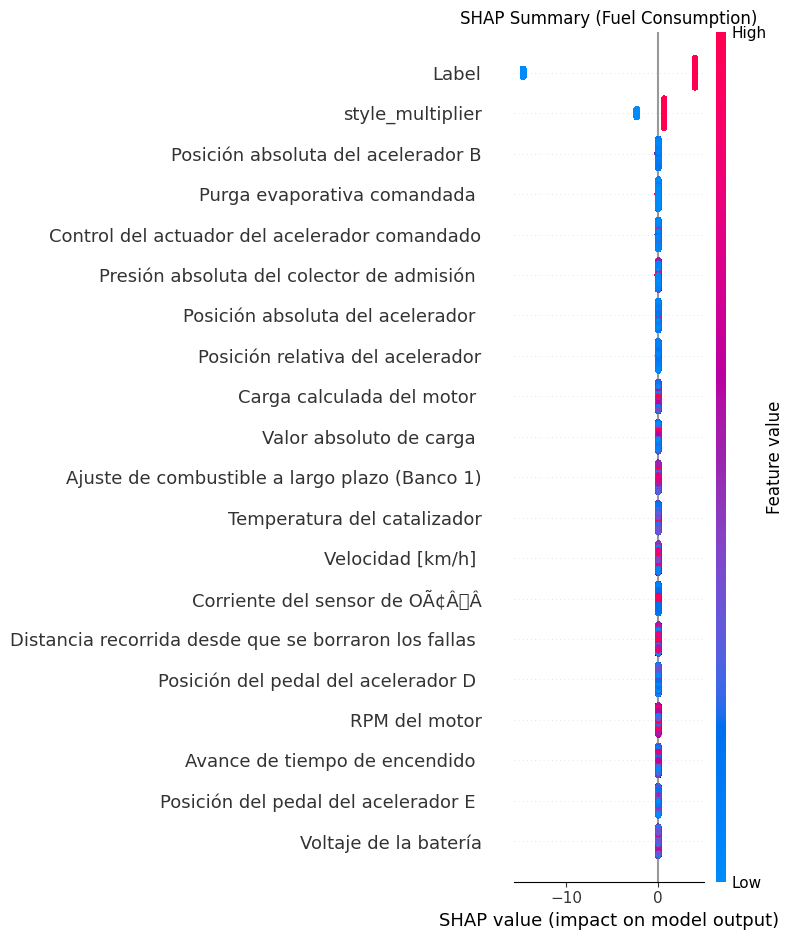

In [27]:
# -------------------------
# SHAP for XGB Fuel model
# -------------------------
# Need transformed feature matrix and fitted xgb model
prep_fitted = xgb_fuel_model.named_steps["prep"]
xgb_fitted  = xgb_fuel_model.named_steps["xgb"]

X_train_trans = prep_fitted.transform(X_train)

# Get feature names after preprocessing
feature_names = []
if len(num_cols) > 0:
    feature_names.extend(num_cols)

if len(cat_cols) > 0:
    ohe = prep_fitted.named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names.extend(cat_feature_names)

explainer = shap.TreeExplainer(xgb_fitted)
shap_values = explainer.shap_values(X_train_trans)

# Summary plot
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Fuel Consumption)")
plt.tight_layout()
plt.show()

In [28]:
results = pd.DataFrame([m1, m2, m3, m4])
results_path = os.path.join(BASE_PATH, "fuel_co2_model_metrics.csv")
results.to_csv(results_path, index=False)
print("Saved metrics:", results_path)
print(results)

joblib.dump(xgb_fuel_model, os.path.join(BASE_PATH, "xgb_fuel_model.joblib"))
joblib.dump(xgb_co2_model,  os.path.join(BASE_PATH, "xgb_co2_model.joblib"))
joblib.dump(rf_fuel_model,  os.path.join(BASE_PATH, "rf_fuel_model.joblib"))
joblib.dump(rf_co2_model,   os.path.join(BASE_PATH, "rf_co2_model.joblib"))

print("Saved models in:", BASE_PATH)

Saved metrics: /content/drive/MyDrive/ML_new_Folder/fuel_co2_model_metrics.csv
      model            r2           mae          rmse
0   RF-Fuel -3.945060e+06  2.103006e+02  2.104851e+02
1    RF-CO2  1.000000e+00  2.032099e-10  2.106157e-10
2  XGB-Fuel -3.945057e+06  2.103006e+02  2.104850e+02
3   XGB-CO2  1.000000e+00  2.654651e-04  9.959306e-04
Saved models in: /content/drive/MyDrive/ML_new_Folder


In [29]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

BASE_PATH = "/content/drive/MyDrive/ML_new_Folder"

xgb_fuel = joblib.load(os.path.join(BASE_PATH, "xgb_fuel_model.joblib"))
rf_fuel  = joblib.load(os.path.join(BASE_PATH, "rf_fuel_model.joblib"))

xgb_co2 = joblib.load(os.path.join(BASE_PATH, "xgb_co2_model.joblib"))
rf_co2  = joblib.load(os.path.join(BASE_PATH, "rf_co2_model.joblib"))

# Load dataset
df = pd.read_csv(os.path.join(BASE_PATH, "OBD_Classified_with_Fuel_CO2.csv"))

# Targets
y_fuel = df["Fuel_Consumption_L_per_100km"].values
y_co2  = df["CO2_g_per_km"].values

# Features (same logic as before)
drop_cols = ["Fuel_Consumption_L_per_100km", "CO2_g_per_km"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, yfuel_train, yfuel_test = train_test_split(
    X, y_fuel, test_size=0.2, random_state=42
)

_, _, yco2_train, yco2_test = train_test_split(
    X, y_co2, test_size=0.2, random_state=42
)

In [31]:
# Fuel
pred_fuel_xgb = xgb_fuel.predict(X_test)
pred_fuel_rf  = rf_fuel.predict(X_test)

# CO2
pred_co2_xgb = xgb_co2.predict(X_test)
pred_co2_rf  = rf_co2.predict(X_test)

In [33]:
ALPHA = 0.7  # XGB weight

fuel_ensemble = ALPHA * pred_fuel_xgb + (1 - ALPHA) * pred_fuel_rf
co2_ensemble  = ALPHA * pred_co2_xgb  + (1 - ALPHA) * pred_co2_rf

In [34]:
def evaluate(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    return {"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse}

In [35]:
res_fuel = []
res_fuel.append(evaluate(yfuel_test, pred_fuel_xgb, "XGB-Fuel"))
res_fuel.append(evaluate(yfuel_test, pred_fuel_rf,  "RF-Fuel"))
res_fuel.append(evaluate(yfuel_test, fuel_ensemble, "Ensemble-Fuel"))

fuel_results_df = pd.DataFrame(res_fuel)
fuel_results_df

XGB-Fuel -> R2: -3945056.6694 | MAE: 210.3006 | RMSE: 210.4850
RF-Fuel -> R2: -3945059.6663 | MAE: 210.3006 | RMSE: 210.4851
Ensemble-Fuel -> R2: -3945057.3744 | MAE: 210.3006 | RMSE: 210.4851


,Model,R2,MAE,RMSE
0,XGB-Fuel,-3.945057e+06,210.300568,210.485039
1,RF-Fuel,-3.945060e+06,210.300645,210.485119
2,Ensemble-Fuel,-3.945057e+06,210.300586,210.485058


from matplotlib import pyplot as plt
_df_63['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_64['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_65['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_66['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_67.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_68.plot(kind='scatter', x='index', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_69.plot(kind='scatter', x='R2', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_70.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_71.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_72.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_73.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_74.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_75['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_76['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_77['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_78['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_79['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_79, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_80['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_80, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_81['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_81, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_82['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_82, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [36]:
res_co2 = []
res_co2.append(evaluate(yco2_test, pred_co2_xgb, "XGB-CO2"))
res_co2.append(evaluate(yco2_test, pred_co2_rf,  "RF-CO2"))
res_co2.append(evaluate(yco2_test, co2_ensemble, "Ensemble-CO2"))

co2_results_df = pd.DataFrame(res_co2)
co2_results_df

XGB-CO2 -> R2: 1.0000 | MAE: 0.0003 | RMSE: 0.0010
RF-CO2 -> R2: 1.0000 | MAE: 0.0000 | RMSE: 0.0000
Ensemble-CO2 -> R2: 1.0000 | MAE: 0.0002 | RMSE: 0.0007


,Model,R2,MAE,RMSE
0,XGB-CO2,1.0,2.654651e-04,9.959306e-04
1,RF-CO2,1.0,2.032067e-10,2.106142e-10
2,Ensemble-CO2,1.0,1.900131e-04,6.977326e-04


from matplotlib import pyplot as plt
_df_43['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_44['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_45['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_46['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_47.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_48.plot(kind='scatter', x='index', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_49.plot(kind='scatter', x='R2', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_50.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_51.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_52.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_53.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_54.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_55['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_56['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_57['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_58['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_59['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_59, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_60['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_60, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_61['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_61, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_62['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_62, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [37]:
ensemble_results = pd.concat([
    fuel_results_df.assign(Target="Fuel"),
    co2_results_df.assign(Target="CO2")
], ignore_index=True)

OUT = os.path.join(BASE_PATH, "ensemble_model_results.csv")
ensemble_results.to_csv(OUT, index=False)

print("Saved ensemble results →", OUT)
ensemble_results

Saved ensemble results → /content/drive/MyDrive/ML_new_Folder/ensemble_model_results.csv


,Model,R2,MAE,RMSE,Target
0,XGB-Fuel,-3.945057e+06,2.103006e+02,2.104850e+02,Fuel
1,RF-Fuel,-3.945060e+06,2.103006e+02,2.104851e+02,Fuel
2,Ensemble-Fuel,-3.945057e+06,2.103006e+02,2.104851e+02,Fuel
3,XGB-CO2,1.000000e+00,2.654651e-04,9.959306e-04,CO2
4,RF-CO2,1.000000e+00,2.032067e-10,2.106142e-10,CO2
5,Ensemble-CO2,1.000000e+00,1.900131e-04,6.977326e-04,CO2


from matplotlib import pyplot as plt
_df_21['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_25.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_26.groupby('Target').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27.plot(kind='scatter', x='index', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_28.plot(kind='scatter', x='R2', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_29.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_30.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_31.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Target')):
  _plot_series(series, series_name, i)
  fig.legend(title='Target', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_32.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_33.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Target')):
  _plot_series(series, series_name, i)
  fig.legend(title='Target', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
_df_34['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_35['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_36['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_37['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Target'].value_counts()
    for x_label, grp in _df_38.groupby('Model')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Model')
_ = plt.ylabel('Target')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_39['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_39, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_40['Target'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_40, x='index', y='Target', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_41['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_41, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_42['Target'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_42, x='R2', y='Target', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [38]:
import os
import joblib
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_PATH = "/content/drive/MyDrive/ML_new_Folder"

xgb_fuel = joblib.load(os.path.join(BASE_PATH, "xgb_fuel_model.joblib"))
xgb_co2  = joblib.load(os.path.join(BASE_PATH, "xgb_co2_model.joblib"))

df = pd.read_csv(os.path.join(BASE_PATH, "OBD_Classified_with_Fuel_CO2.csv"))

In [39]:
# Targets
y_fuel = df["Fuel_Consumption_L_per_100km"]
y_co2  = df["CO2_g_per_km"]

# Features
drop_cols = ["Fuel_Consumption_L_per_100km", "CO2_g_per_km"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Train split (same random_state)
from sklearn.model_selection import train_test_split
X_train, X_test, _, _ = train_test_split(X, y_fuel, test_size=0.2, random_state=42)

In [40]:
# For Fuel model
prep_fuel = xgb_fuel.named_steps["prep"]
model_fuel = xgb_fuel.named_steps["xgb"]

X_train_trans = prep_fuel.transform(X_train)

In [41]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

feature_names = []
if num_cols:
    feature_names.extend(num_cols)

if cat_cols:
    ohe = prep_fuel.named_transformers_["cat"].named_steps["onehot"]
    cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names.extend(cat_features)

len(feature_names), X_train_trans.shape

(36, (444000, 36))

In [42]:
explainer_fuel = shap.TreeExplainer(model_fuel)
shap_values_fuel = explainer_fuel.shap_values(X_train_trans)

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


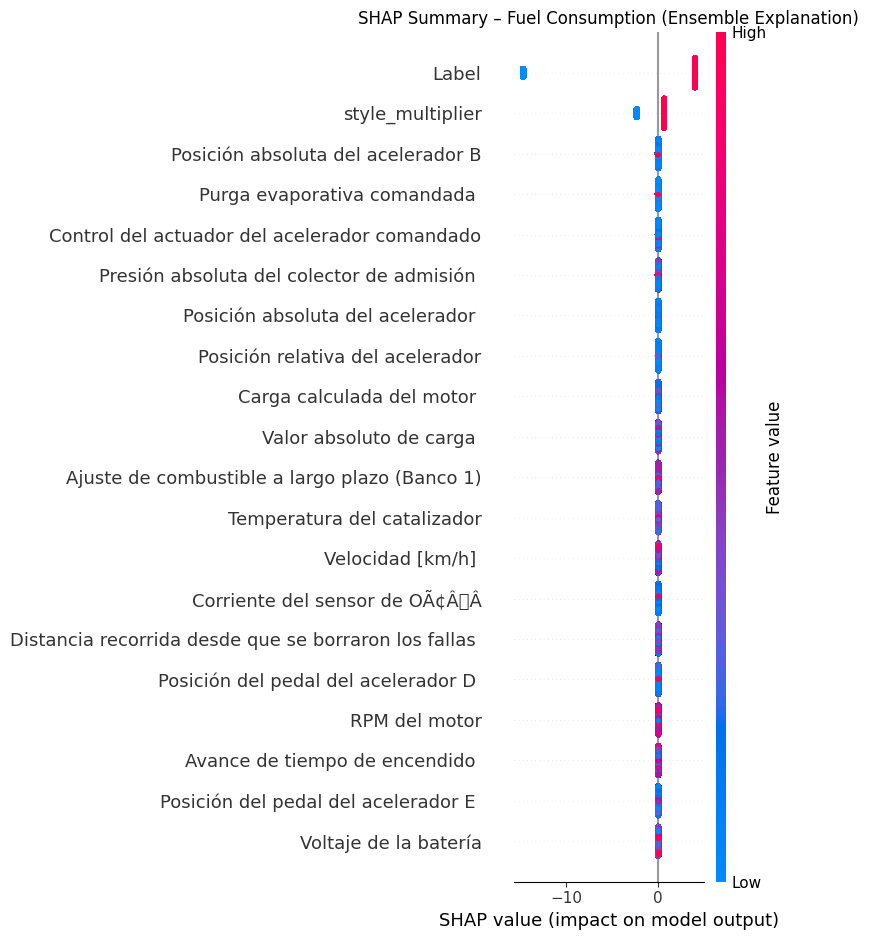

In [43]:
shap.summary_plot(
    shap_values_fuel,
    X_train_trans,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Summary – Fuel Consumption (Ensemble Explanation)")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


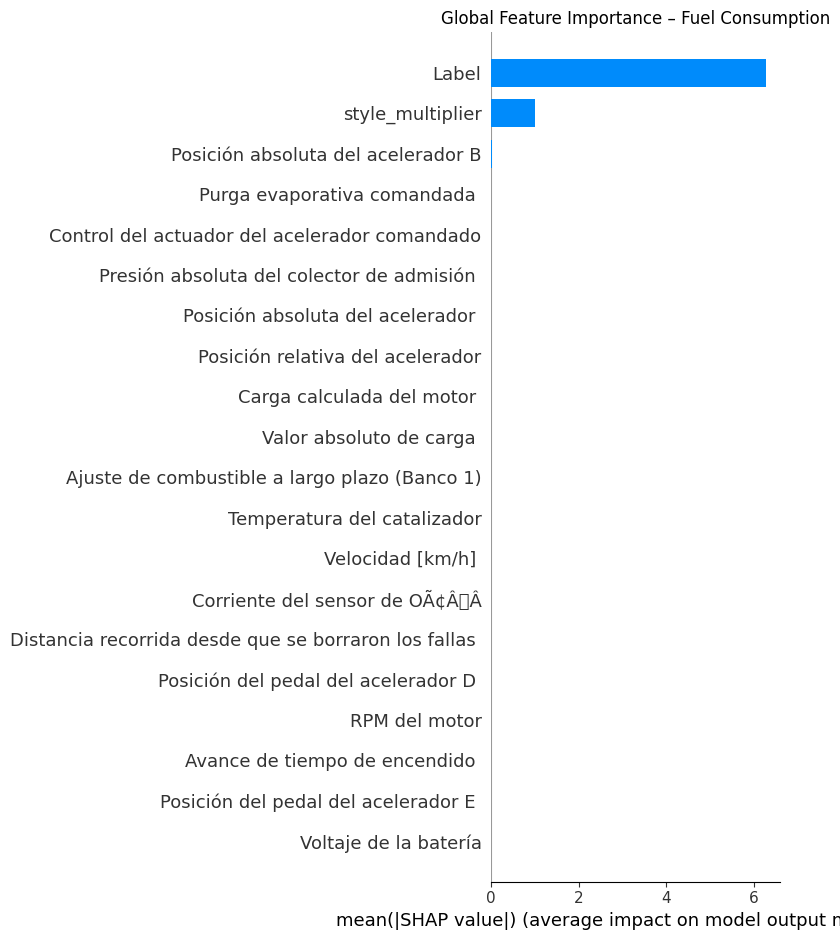

In [44]:
shap.summary_plot(
    shap_values_fuel,
    X_train_trans,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title("Global Feature Importance – Fuel Consumption")
plt.tight_layout()
plt.show()

In [45]:
# Extract for CO2
prep_co2 = xgb_co2.named_steps["prep"]
model_co2 = xgb_co2.named_steps["xgb"]

X_train_trans_co2 = prep_co2.transform(X_train)

ohe2 = prep_co2.named_transformers_["cat"].named_steps["onehot"] if cat_cols else None
feature_names2 = num_cols.copy()
if ohe2:
    feature_names2.extend(ohe2.get_feature_names_out(cat_cols).tolist())

explainer_co2 = shap.TreeExplainer(model_co2)
shap_values_co2 = explainer_co2.shap_values(X_train_trans_co2)

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


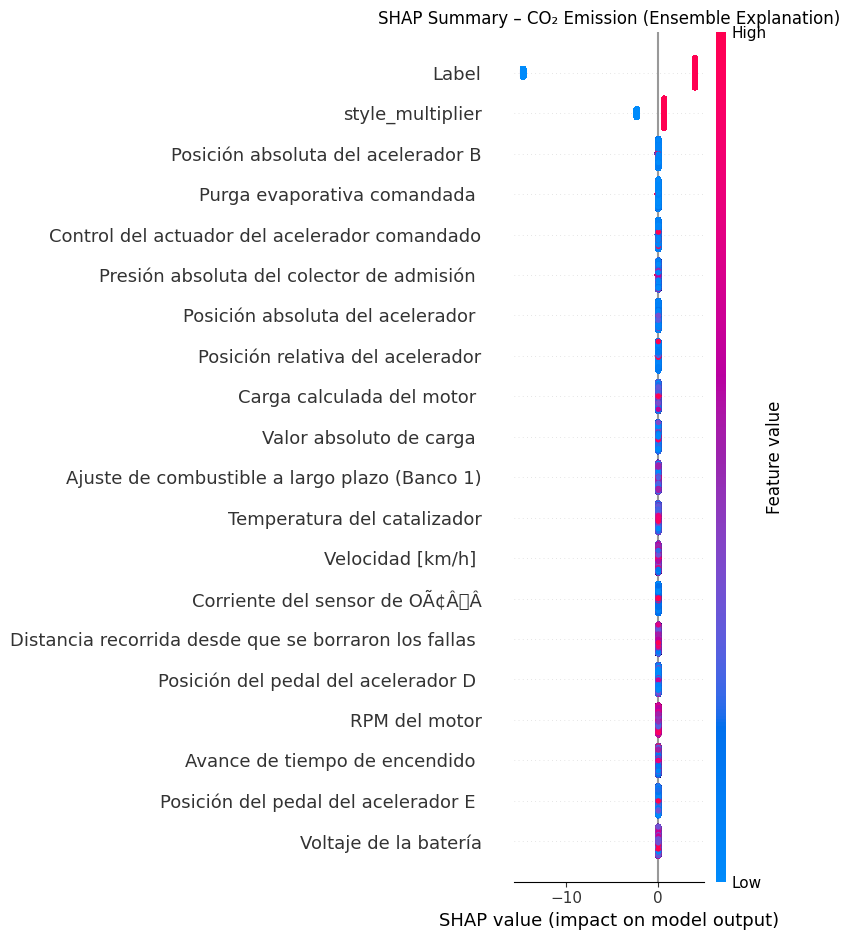

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


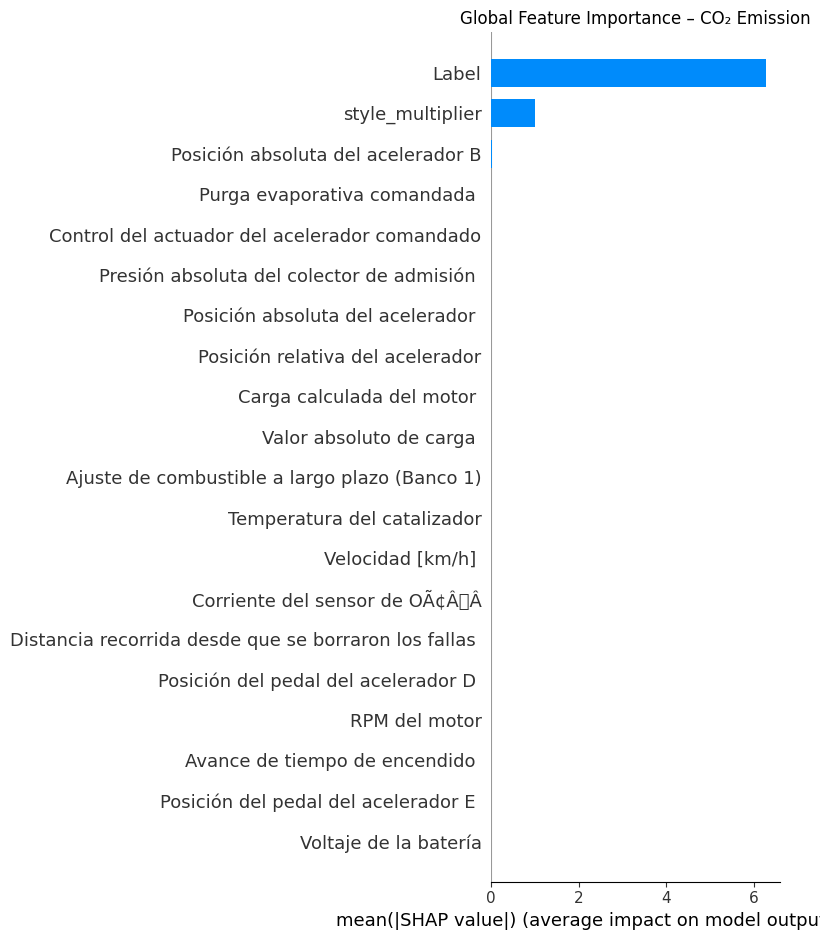

In [46]:
shap.summary_plot(
    shap_values_co2,
    X_train_trans_co2,
    feature_names=feature_names2,
    show=False
)
plt.title("SHAP Summary – CO₂ Emission (Ensemble Explanation)")
plt.tight_layout()
plt.show()

shap.summary_plot(
    shap_values_co2,
    X_train_trans_co2,
    feature_names=feature_names2,
    plot_type="bar",
    show=False
)
plt.title("Global Feature Importance – CO₂ Emission")
plt.tight_layout()
plt.show()

In [48]:
import os
import pandas as pd
import numpy as np

BASE_PATH = "/content/drive/MyDrive/ML_new_Folder"
DATA_PATH = os.path.join(BASE_PATH, "OBD-II Driving Data - Classified.csv")

df = pd.read_csv(DATA_PATH, encoding='latin1')
print(df.shape)
print(df.columns.tolist())

(555000, 35)
['Voltaje de la batería', 'Carga calculada del motor ', 'Temperatura del lí\xadquido de enfriamiento del motor', 'Ajuste de combustible a corto plazo (Banco 1) ', 'Ajuste de combustible a largo plazo (Banco 1)', 'Presión absoluta del colector de admisión ', 'RPM del motor', 'Velocidad [km/h] ', 'Avance de tiempo de encendido ', 'Temperatura del aire del colector de admisión', 'Posición absoluta del acelerador ', 'Voltaje del sensor de labda ', 'Distancia recorrida con la luz indicadora de falla encendida', 'Purga evaporativa comandada ', 'Entrada de nivel de combustible ', 'Nímero de calentamientos desde que se borraron los fallas ', 'Distancia recorrida desde que se borraron los fallas ', 'Presión barométrica ', 'Relación de equivalencia del sensor de oxigeno', 'Corriente del sensor de OÃ¢Â\x82Â', 'Temperatura del catalizador', 'Voltaje del módulo de control', 'Valor absoluto de carga ', 'Relación de equivalencia comandada por aire/combustible ', 'Posición relativa del ac

In [49]:
# Automatically detect class/label column
label_col = None
for c in df.columns:
    if any(k in c.lower() for k in ["class", "label", "style", "behavior"]):
        label_col = c
        break

print("Label column:", label_col)
print(df[label_col].value_counts())

Label column: Label
Label
1    436602
0    118398
Name: count, dtype: int64


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=[label_col])
y = df[label_col]

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

In [52]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="mlogloss"
)

model = Pipeline([
    ("prep", preprocess),
    ("xgb", clf)
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<Figure size 600x500 with 0 Axes>

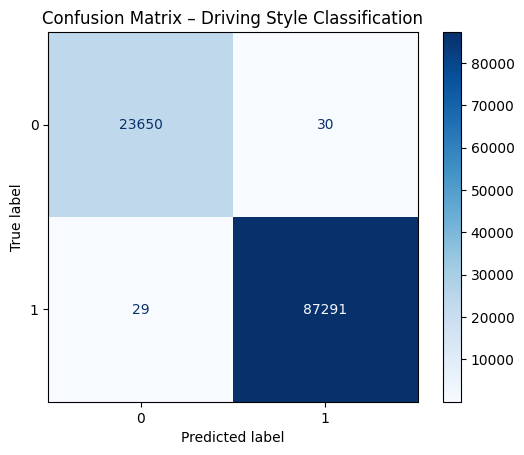

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Driving Style Classification")
plt.show()

In [55]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        y_pred,
        target_names=[str(c) for c in le.classes_]
    )
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23680
           1       1.00      1.00      1.00     87320

    accuracy                           1.00    111000
   macro avg       1.00      1.00      1.00    111000
weighted avg       1.00      1.00      1.00    111000



Accuracy part for Driving Style Classification

In [57]:
import os
import pandas as pd
import numpy as np

BASE_PATH = "/content/drive/MyDrive/ML_new_Folder"
DATA_PATH = os.path.join(BASE_PATH, "OBD-II Driving Data - Classified.csv")

df = pd.read_csv(DATA_PATH, encoding='latin1')

In [58]:
label_col = None
for c in df.columns:
    if any(k in c.lower() for k in ["class", "label", "style", "behavior"]):
        label_col = c
        break

print("Driving style label column:", label_col)
print(df[label_col].value_counts())

Driving style label column: Label
Label
1    436602
0    118398
Name: count, dtype: int64


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=[label_col])
y = df[label_col]

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

In [61]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Baseline – Random Forest
rf_model = Pipeline([
    ("prep", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Improved – XGBoost
xgb_model = Pipeline([
    ("prep", preprocess),
    ("xgb", XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="mlogloss",
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def accuracy_metrics(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "F1-score": f1_score(y_true, y_pred, average="weighted")
    }

results = [
    accuracy_metrics(y_test, rf_pred, "Random Forest (Baseline)"),
    accuracy_metrics(y_test, xgb_pred, "XGBoost (Improved)")
]

accuracy_df = pd.DataFrame(results)
accuracy_df

,Model,Accuracy,Precision,Recall,F1-score
0,Random Forest (Baseline),0.999811,0.999811,0.999811,0.999811
1,XGBoost (Improved),0.999468,0.999468,0.999468,0.999468


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Recall', y='F1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['F1-score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('F1-score')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

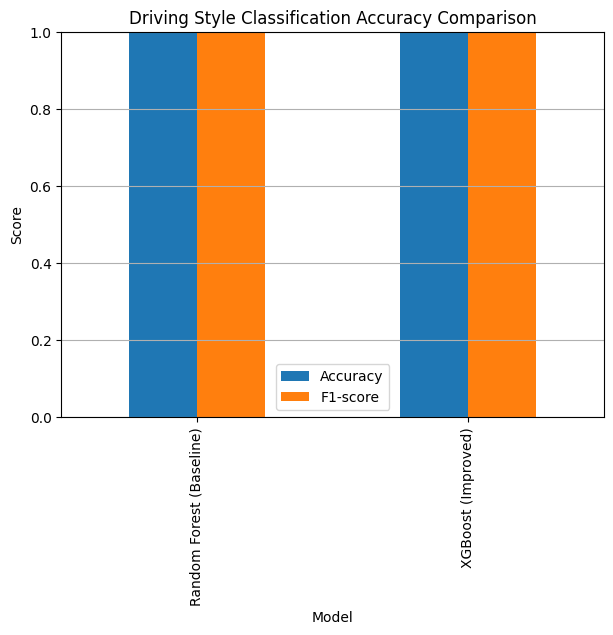

In [63]:
import matplotlib.pyplot as plt

accuracy_df.set_index("Model")[["Accuracy", "F1-score"]].plot(
    kind="bar",
    figsize=(7,5)
)
plt.title("Driving Style Classification Accuracy Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()